# Import Dependencies

In [1]:
# DATA MANIPULTION 
import pandas as pd 
import numpy as np

# DATA VIZ
import matplotlib.pyplot as plt
import seaborn as sns

# STATS
from scipy import stats
from statsmodels.graphics.gofplots import qqplot

# MACHINE LEARNING
## MODEL SELECTION
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
## SCALERS
from sklearn.preprocessing import RobustScaler, StandardScaler
# LINEAR MODELS
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
# NEIGHBORS
from sklearn.neighbors import KNeighborsRegressor
# SVM
from sklearn.svm import SVR
# TREES AND ENSEMBLE METHODS
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
## EVALUATION
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
## MODEL TUNING
from sklearn.model_selection import GridSearchCV

# SAVE MODEL
import joblib

# Load Training Dataset - First Look

In [2]:
df = pd.read_csv('data_files/train.csv')

In [3]:
df.head()

,gender,age,height,weight,bust_circumference,waist_circumference,hip_circumference
0,M,18.0,"1,674",52.9,790,655,851
1,M,18.0,"1,678",55.8,825,654,880
2,M,23.0,"1,790",57.5,800,650,870
3,F,37.0,"1,626",66.3,962,820,997
4,M,24.0,"1,722",69.2,948,785,937


In [4]:
df.shape

(5137, 7)

In [5]:
df.dtypes

gender                  object
age                    float64
height                  object
weight                 float64
bust_circumference      object
waist_circumference     object
hip_circumference       object
dtype: object

## Null Values

In [6]:
df.isnull().sum()

gender                 1
age                    1
height                 2
weight                 7
bust_circumference     4
waist_circumference    4
hip_circumference      4
dtype: int64

In [9]:
rows_with_na = df[df.isnull().any(axis=1)]
rows_with_na

,gender,age,height,weight,bust_circumference,waist_circumference,hip_circumference
1801,F,19.0,"1,620",NaN,775,622,850
2360,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3258,M,17.0,"1,762",NaN,836,690,900
3303,M,31.0,"1,725",NaN,NaN,NaN,NaN
3752,M,20.0,"1,821",NaN,931,762,942
4189,M,22.0,"1,730",NaN,NaN,NaN,NaN
4603,F,63.0,"1,573",NaN,"1,002",910,928
4876,M,37.0,NaN,83.9,NaN,NaN,NaN


## Duplicates

In [7]:
df.duplicated().sum()

4

In [12]:
duplicate_rows = df[df.duplicated(keep=False)]
duplicate_rows

,gender,age,height,weight,bust_circumference,waist_circumference,hip_circumference
378,M,53.0,"1,629",61.6,870,791,876
413,M,53.0,"1,629",61.6,870,791,876
1240,M,29.0,"1,724",87.1,"1,021",940,"1,031"
2215,M,20.0,"1,827",97.1,995,991,"1,058"
2356,M,20.0,"1,827",97.1,995,991,"1,058"
2633,F,33.0,"1,562",65.1,915,834,991
3007,M,29.0,"1,724",87.1,"1,021",940,"1,031"
4839,F,33.0,"1,562",65.1,915,834,991


## Outliers

In [34]:
# Create Functions to deal with outliers

def get_outliers(df, column_name):
    # Calculate the IQR for the column
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    # Identify the outliers in the column
    outliers = df[(df[column_name] < (Q1 - 1.5 * IQR)) | (df[column_name] > (Q3 + 1.5 * IQR))]

    # Print the number of outliers
    print(f"Number of outliers in the {column_name} column: {len(outliers)} -- {round(len(outliers)/len(df)*100, 2)}%")

def remove_outliers(df, column_name):
    df = df[~((df[column_name] < (Q1 - 1.5 * IQR)) | (df[column_name] > (Q3 + 1.5 * IQR)))]

# Clean Data

In [20]:
def get_train(df):
    train = df.dropna(how='any')
    train = train.drop_duplicates()
    # convert gender to binary values
    train.gender = train.gender.apply(lambda x: 0 if x == 'F' else 1)
    # convert measurements to integer and from MM to CM
    train[['height', 'bust_circumference', 'waist_circumference', 'hip_circumference']] = train[['height', 'bust_circumference', 'waist_circumference', 'hip_circumference']].apply(lambda x: x.str.replace(',', '').astype(int) / 10)
    return train

In [21]:
train = get_train(df)
train.head()

,gender,age,height,weight,bust_circumference,waist_circumference,hip_circumference
0,1,18.0,167.4,52.9,79.0,65.5,85.1
1,1,18.0,167.8,55.8,82.5,65.4,88.0
2,1,23.0,179.0,57.5,80.0,65.0,87.0
3,0,37.0,162.6,66.3,96.2,82.0,99.7
4,1,24.0,172.2,69.2,94.8,78.5,93.7


In [22]:
train.dtypes

gender                   int64
age                    float64
height                 float64
weight                 float64
bust_circumference     float64
waist_circumference    float64
hip_circumference      float64
dtype: object

In [23]:
train.duplicated().sum()

0

In [24]:
train.isnull().sum()

gender                 0
age                    0
height                 0
weight                 0
bust_circumference     0
waist_circumference    0
hip_circumference      0
dtype: int64

In [25]:
train.gender.value_counts()

0    2572
1    2553
Name: gender, dtype: int64

# Exploration / Visualization

## Distribution and Gaussianity of Features and Target Values

In [48]:
def show_distribution_and_gaussianity(df, column_name):
    title = column_name.split('_')[0].capitalize()
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # Bust
    ax[0].set_title(f"Distribution of {title}")
    sns.histplot(data=df, x=column_name, hue='gender', kde=True, ax=ax[0])

    ax[1].set_title(f"Boxplot of {title}")
    sns.boxplot(data=df, x=column_name, ax=ax[1])

    ax[2].set_title(f"Gaussianity of {title}")
    qqplot(df[column_name], line='s', ax=ax[2]);

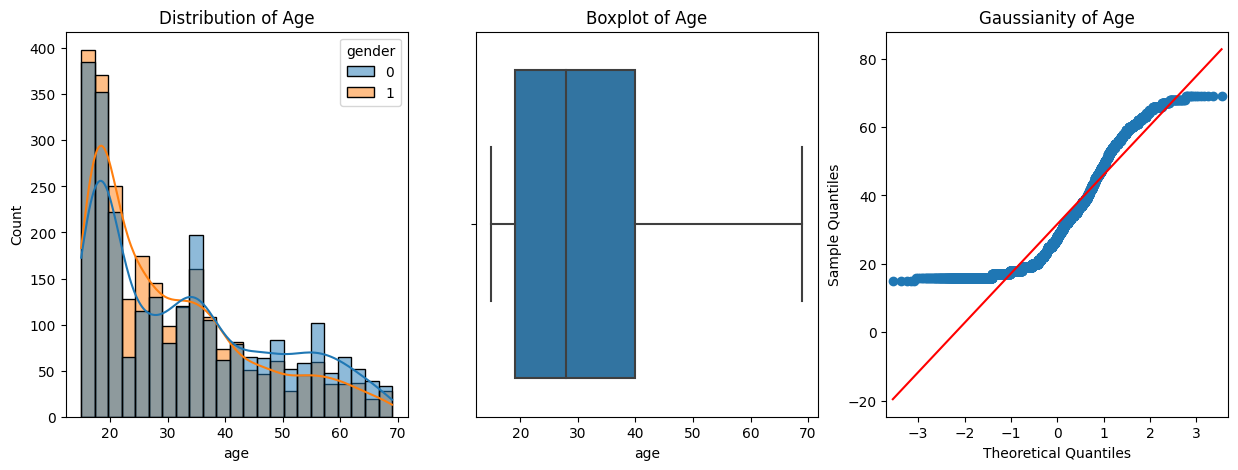

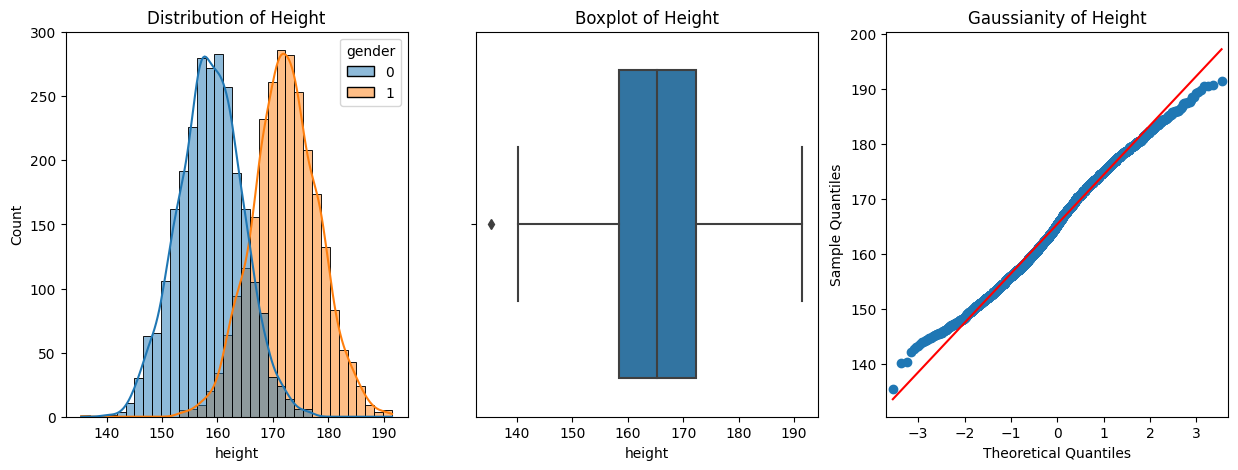

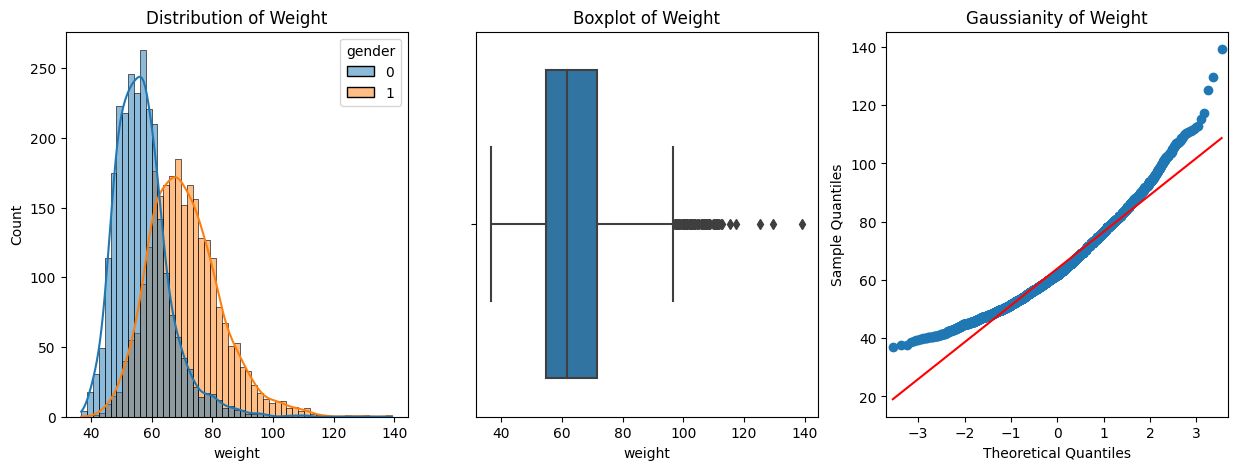

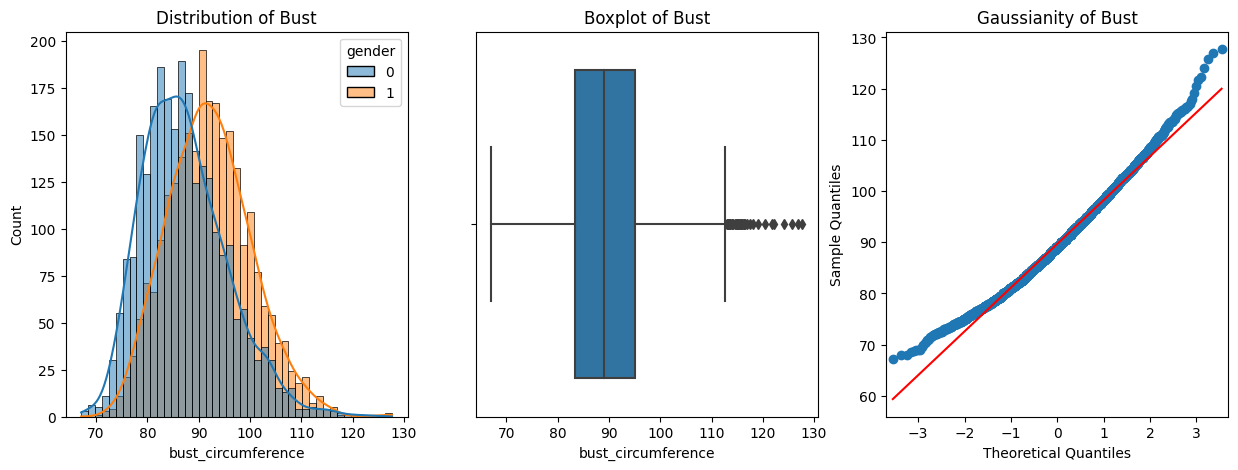

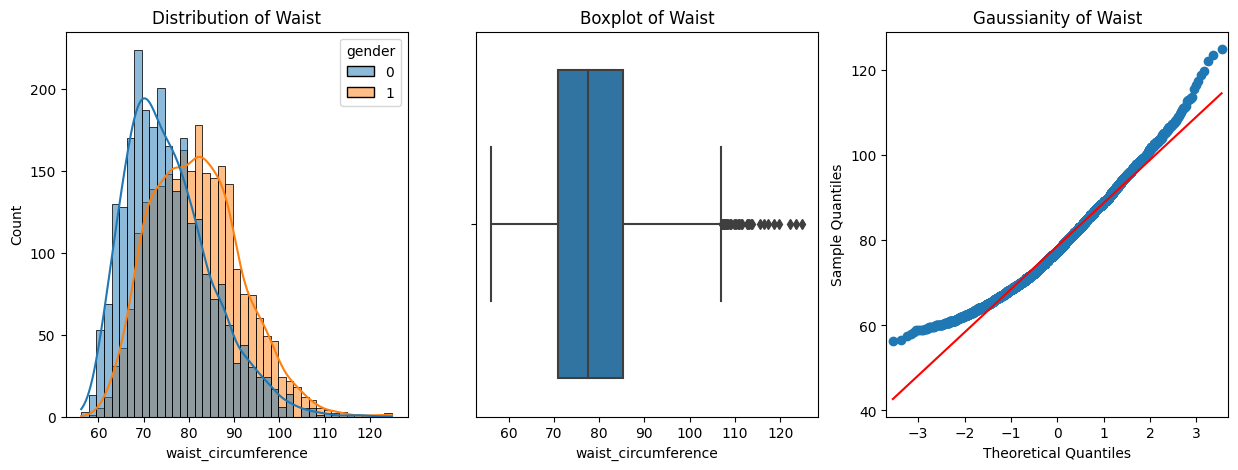

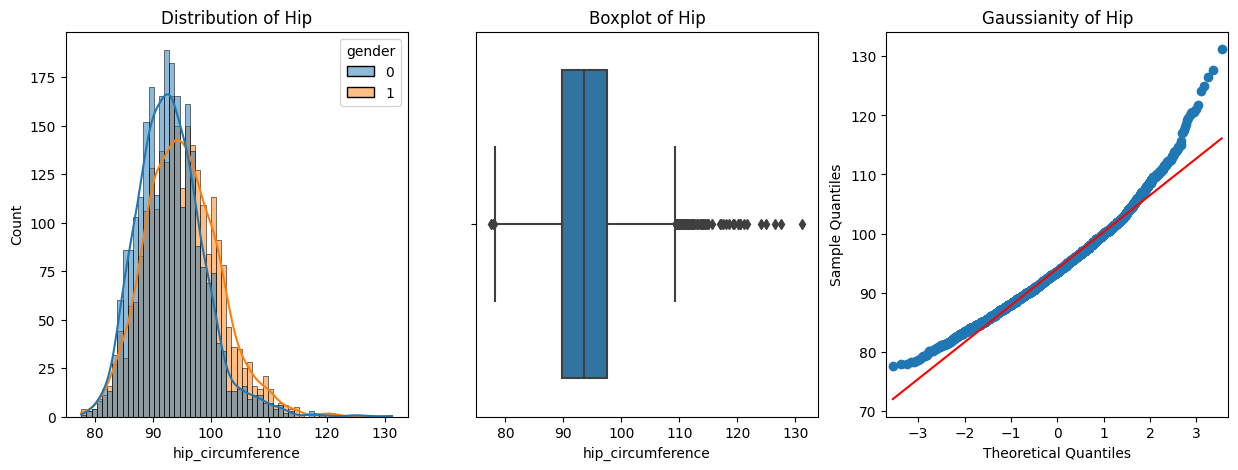

In [49]:
check_columns = train.drop(columns='gender')
for column in check_columns:
    show_distribution_and_gaussianity(train, column)

## Gender Count

0    2572
1    2553
Name: gender, dtype: int64


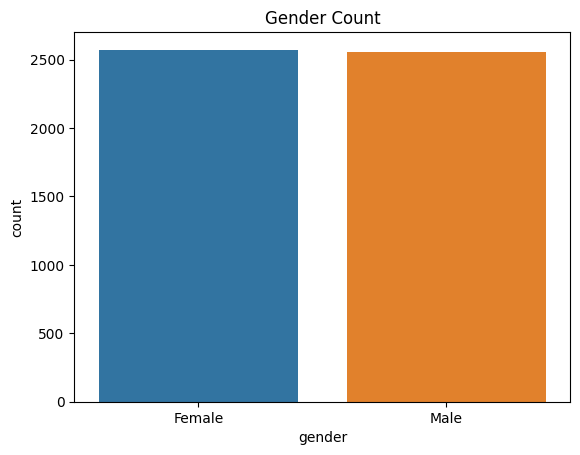

In [43]:
print(train.gender.value_counts())

sns.countplot(data=train, x='gender')
plt.title('Gender Count')
plt.xticks([0, 1], ['Female', 'Male'])
plt.show();

## Correlation between Features / Target Values

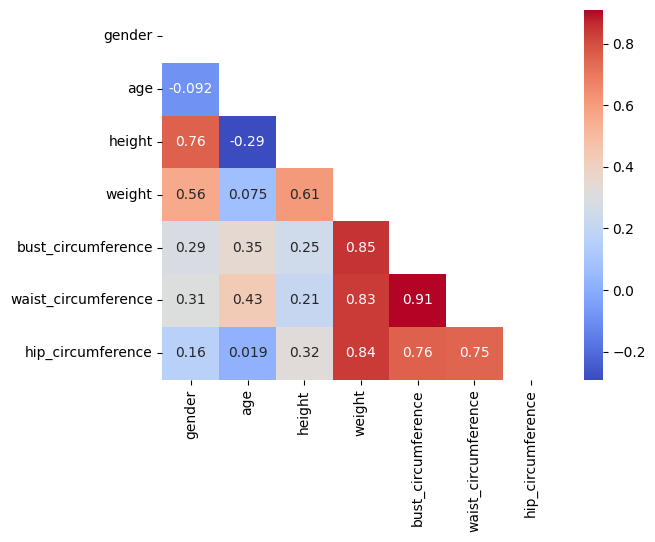

In [52]:
corr_matrix = train.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=True, mask=mask)
plt.show();

## Outliers

In [36]:
for x in check_columns:
    get_outliers(train, x)

Number of outliers in the age column: 0 -- 0.0%
Number of outliers in the height column: 1 -- 0.02%
Number of outliers in the weight column: 81 -- 1.58%
Number of outliers in the bust_circumference column: 42 -- 0.82%
Number of outliers in the waist_circumference column: 35 -- 0.68%
Number of outliers in the hip_circumference column: 103 -- 2.01%


# Baseline Model

## Use average values of bust, waist, hip circumferences as predictions

In [53]:
# get average values

avg_bust = train.bust_circumference.mean()
avg_waist = train.waist_circumference.mean()
avg_hip = train.hip_circumference.mean()

avg_bust, avg_waist, avg_hip

(89.66331707317073, 78.5856780487805, 94.05149268292683)

In [56]:
# create series of same shape as dataframe

bust_pred_baseline = pd.Series([avg_bust]*train.shape[0])
waist_pred_baseline = pd.Series([avg_waist]*train.shape[0])
hip_pred_baseline = pd.Series([avg_hip]*train.shape[0])

bust_pred_baseline.head()

0    89.663317
1    89.663317
2    89.663317
3    89.663317
4    89.663317
dtype: float64

In [59]:
def get_score(metric, true_values, predicted_values):
    if metric == "rmse":
        score = np.sqrt(mean_squared_error(true_values, predicted_values))
    elif metric == "r2":
        score = r2_score(true_values, predicted_values)
    else:
        raise ValueError("Invalid metric specified.")
    
    return score

def show_score()

In [60]:
get_score('rmse', train['bust_circumference'], bust_pred_baseline)

8.541564643436306

In [57]:
bust_mse = np.sqrt(mean_squared_error(train['bust_circumference'], bust_pred_baseline))
waist_mse = np.sqrt(mean_squared_error(train['waist_circumference'], waist_pred_baseline))
hip_mse = np.sqrt(mean_squared_error(train['hip_circumference'], hip_pred_baseline))

print("Bust RMSE:", bust_mse)
print("Waist RMSE:", waist_mse)
print("Hip RMSE:", hip_mse)

Root Mean Squared Error: 8.541564643436306
Root Mean Squared Error: 10.128873857118599
Root Mean Squared Error: 6.213921444878201


In [61]:
bust_r2 = r2_score(train['bust_circumference'], bust_pred_baseline)
waist_r2 = r2_score(train['waist_circumference'], waist_pred_baseline)
hip_r2 = r2_score(train['hip_circumference'], hip_pred_baseline)

print("Bust R2:", bust_r2)
print("Waist R2:", waist_r2)
print("Hip R2:", hip_r2)

Bust R2: 0.0
Waist R2: 0.0
Hip R2: 0.0


# First Model

## Set X, Y Features / Test Train Split

In [63]:
X = train.drop(columns=['bust_circumference', 'waist_circumference', 'hip_circumference'])
y = train[['bust_circumference', 'waist_circumference', 'hip_circumference']]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, random_state=22)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4100, 4), (1025, 4), (4100, 3), (1025, 3))

## Scale Features

In [64]:
rob = RobustScaler()

X_train_scaled = pd.DataFrame(rob.fit_transform(X_train),
                              columns=rob.get_feature_names_out()
                             )
X_test_scaled = pd.DataFrame(rob.transform(X_test),
                              columns=rob.get_feature_names_out()
                             )

X_train_scaled.head()

,gender,age,height,weight
0,0.0,0.190476,-0.741007,-0.088757
1,0.0,0.238095,0.194245,0.071006
2,0.0,1.190476,-0.050360,-0.284024
3,0.0,-0.523810,-0.143885,-0.810651
4,1.0,-0.476190,0.776978,-0.147929


## Linear Regression

In [70]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_test_pred = model.predict(X_test_scaled)

test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f'Overall R2: {test_r2}')
print(f'Overall RMSE: {test_rmse}')

Overall R2: 0.8694099701647194
Overall RMSE: 2.985775185056763


### Check for Overfitting

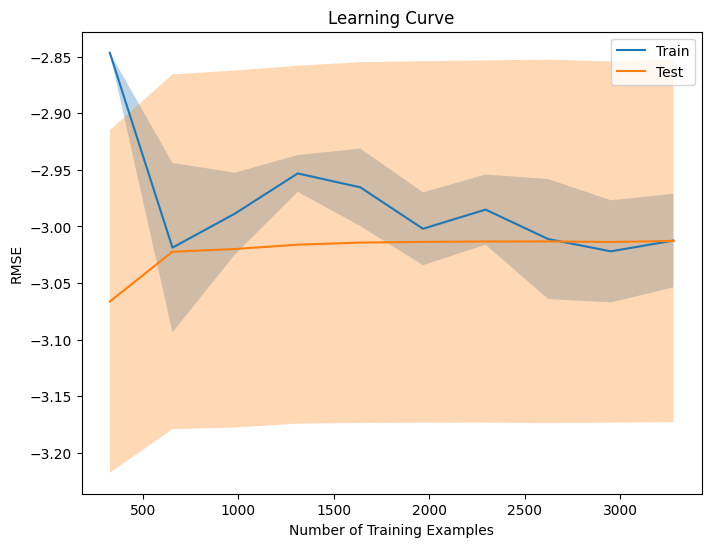

In [79]:
from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer, mean_squared_error

# Define custom scoring function for RMSE
def rmse_scorer(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return -rmse  # Minimize negative RMSE (equivalent to maximizing RMSE)

train_sizes, train_scores, test_scores = learning_curve(
    model, X_train_scaled, y_train, cv=5, scoring=make_scorer(rmse_scorer), train_sizes=np.linspace(0.1, 1.0, 10))

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label='Train')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.3)
plt.plot(train_sizes, test_mean, label='Test')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.3)
plt.xlabel('Number of Training Examples')
plt.ylabel('RMSE')
plt.title('Linear Regression Learning Curve')
plt.legend()
plt.show();

## Random Forest Regressor

In [76]:
rfr = RandomForestRegressor()
rfr.fit(X_train_scaled, y_train)
y_test_pred = rfr.predict(X_test_scaled)

test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f'Overall R2: {test_r2}')
print(f'Overall RMSE: {test_rmse}')

Overall R2: 0.8576672398753743
Overall RMSE: 3.1159719437352975


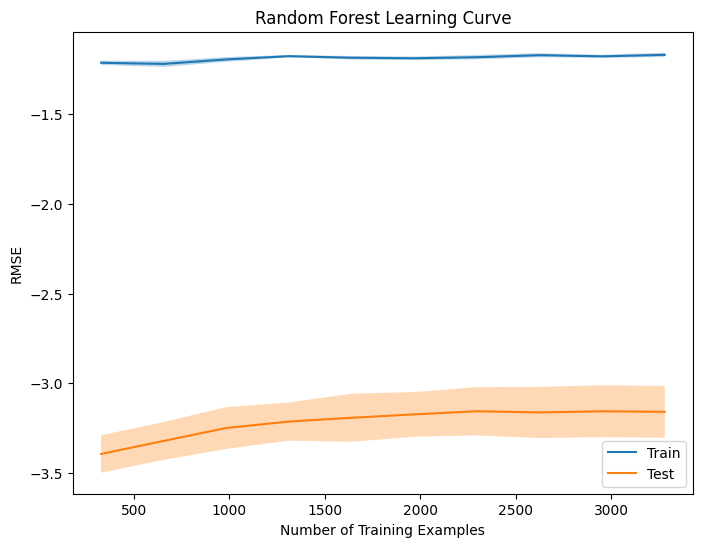

In [80]:
train_sizes, train_scores, test_scores = learning_curve(
    rfr, X_train_scaled, y_train, cv=5, scoring=make_scorer(rmse_scorer), train_sizes=np.linspace(0.1, 1.0, 10))

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label='Train')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.3)
plt.plot(train_sizes, test_mean, label='Test')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.3)
plt.xlabel('Number of Training Examples')
plt.ylabel('RMSE')
plt.title('Random Forest Learning Curve')
plt.legend()
plt.show();

# Model Tuning

In [81]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 5, 10],       # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]     # Minimum number of samples required to be a leaf node
}

# Create the Random Forest Regressor
rfr = RandomForestRegressor(random_state=42)

# Perform grid search
grid_search = GridSearchCV(rfr, param_grid=param_grid, scoring=make_scorer(rmse_scorer), cv=5)
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score (RMSE):", grid_search.best_score_)

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best Score (RMSE): -3.0431108489907666


# Check Test Dataset

In [11]:
test = pd.read_csv('data_files/test.csv')
test.head()

,gender,age,height,weight
0,M,27,"1,729",74.7
1,M,25,"1,645",58.6
2,M,28,"1,786",75.2
3,M,19,"1,686",60.8
4,M,24,"1,764",68.3


In [14]:
test.dtypes

gender     object
age         int64
height     object
weight    float64
dtype: object

In [12]:
test.isnull().sum()

gender    0
age       0
height    0
weight    1
dtype: int64

In [13]:
test.duplicated().sum()

0

# Preprocessing

In [15]:
def get_features(df):
    # change gender to binary
    # convert height to float
    # convert height to cm
    # impute missing values
    return df
    

# Pipeline / Functions / Save Final Model